## Import Modules

In [1]:
# Import all the required modules
import math
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
import sys
if 'google.colab' in sys.modules:
# Add the directory containing your module to the Python path
  from google.colab import drive
  drive.mount('/content/drive')
  module_path = '/content/drive/MyDrive/Colab_Notebooks/Session8'
  sys.path.append(module_path)
  print(sys.path)


Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab_Notebooks/Session8']


# Dataset Analysis

## Extract and Load the Data

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:10<00:00, 15931391.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


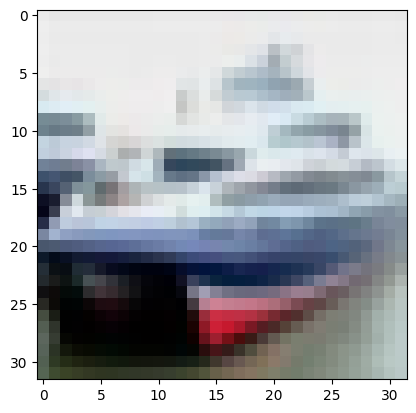

In [4]:
from utils import get_cifar_statistics
#import utils
#dir(utils)
get_cifar_statistics(train, data_set_type="Train")
get_cifar_statistics(test, data_set_type="Test")

## Visualize Training Data

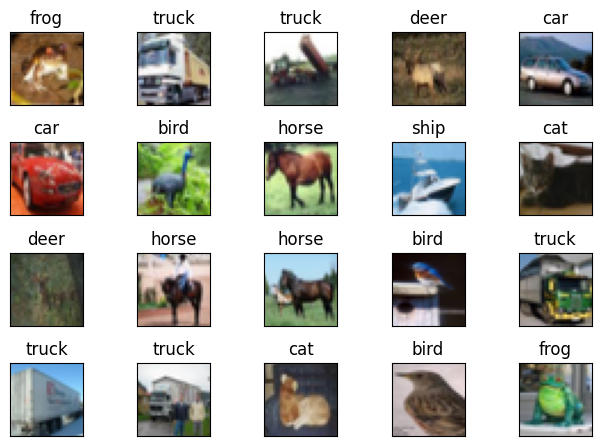

In [5]:
from utils import display_data_samples
DISPLAY_SAMPLES = 20
display_data_samples(train, DISPLAY_SAMPLES, classes, dataset='CIFAR')

## Transformations

In [6]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    'horizontalflip': transforms.RandomHorizontalFlip(),
    'rotation': transforms.RandomRotation(15),
    'standardize': transforms.ToTensor(),
    'normalize': transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    # 'affine': transforms.RandomAffine(degrees=(-7, 7), translate=(0.1, 0.1), scale=(0.09, 1.0)),
    # 'randomcrop': transforms.RandomResizedCrop((32, 32), (0.85, 1.0)),
    # 'cutout': transforms.RandomErasing()
}

# Test Phase transformations
test_set_transforms = {
    'standardize': transforms.ToTensor(),
    'normalize': transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
}

train_transforms = transforms.Compose(train_set_transforms.values())
test_transforms = transforms.Compose(test_set_transforms.values())

In [7]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Dataloader Arguments & Test/Train Dataloaders

## Parameters

In [8]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.02
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
MAX_LR = 0.1



In [9]:
SEED = 50

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [10]:
from models import Session8_Model as Net, get_summary
model =  Net(normalization='group',number_of_groups=2,dropout_value=0.1).to(device)
get_summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]             540
              ReLU-2           [-1, 20, 32, 32]               0
         GroupNorm-3           [-1, 20, 32, 32]              40
           Dropout-4           [-1, 20, 32, 32]               0
            Conv2d-5           [-1, 20, 32, 32]           3,600
              ReLU-6           [-1, 20, 32, 32]               0
         GroupNorm-7           [-1, 20, 32, 32]              40
           Dropout-8           [-1, 20, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             320
             ReLU-10           [-1, 16, 32, 32]               0
        GroupNorm-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 26,

In [11]:
STEPS_PER_EPOCH =int(len(train_loader)*1)
print(f'STEPS_PER_EPOCH {STEPS_PER_EPOCH}')

STEPS_PER_EPOCH 98


## Model Training and Testing

In [12]:
from training_utils import train, test
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Optimization algorithm to update the weights
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Scheduler to change the learning rate after specific number of epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

criterion = F.nll_loss
print(f'STEPS_PER_EPOCH {STEPS_PER_EPOCH}')

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

STEPS_PER_EPOCH 98
Epoch 1


Train: Loss=1.7856 Batch_id=97 Accuracy=25.45: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


Test set: Average loss: 1.8789, Accuracy: 2972/10000 (29.72%)

Epoch 2


Train: Loss=1.6274 Batch_id=97 Accuracy=38.19: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


Test set: Average loss: 1.4723, Accuracy: 4480/10000 (44.80%)

Epoch 3


Train: Loss=1.5515 Batch_id=97 Accuracy=44.49: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]


Test set: Average loss: 1.4332, Accuracy: 4712/10000 (47.12%)

Epoch 4


Train: Loss=1.5556 Batch_id=97 Accuracy=47.51: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]


Test set: Average loss: 1.3728, Accuracy: 5061/10000 (50.61%)

Epoch 5


Train: Loss=1.2411 Batch_id=97 Accuracy=51.78: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Test set: Average loss: 1.2585, Accuracy: 5336/10000 (53.36%)

Epoch 6


Train: Loss=1.0397 Batch_id=97 Accuracy=55.90: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


Test set: Average loss: 1.1346, Accuracy: 5883/10000 (58.83%)

Epoch 7


Train: Loss=1.1055 Batch_id=97 Accuracy=58.61: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]


Test set: Average loss: 1.1719, Accuracy: 5760/10000 (57.60%)

Epoch 8


Train: Loss=1.0438 Batch_id=97 Accuracy=59.62: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]


Test set: Average loss: 1.1240, Accuracy: 5976/10000 (59.76%)

Epoch 9


Train: Loss=1.1113 Batch_id=97 Accuracy=61.88: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Test set: Average loss: 1.1262, Accuracy: 6006/10000 (60.06%)

Epoch 10


Train: Loss=0.9577 Batch_id=97 Accuracy=62.05: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


Test set: Average loss: 0.9896, Accuracy: 6502/10000 (65.02%)

Epoch 11


Train: Loss=0.9678 Batch_id=97 Accuracy=63.49: 100%|██████████| 98/98 [00:16<00:00,  5.79it/s]


Test set: Average loss: 1.0131, Accuracy: 6390/10000 (63.90%)

Epoch 12


Train: Loss=1.0203 Batch_id=97 Accuracy=64.77: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]


Test set: Average loss: 0.9850, Accuracy: 6470/10000 (64.70%)

Epoch 13


Train: Loss=0.9732 Batch_id=97 Accuracy=65.34: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]


Test set: Average loss: 0.9426, Accuracy: 6668/10000 (66.68%)

Epoch 14


Train: Loss=0.9261 Batch_id=97 Accuracy=66.31: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]


Test set: Average loss: 0.9411, Accuracy: 6660/10000 (66.60%)

Epoch 15


Train: Loss=0.8944 Batch_id=97 Accuracy=67.34: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]


Test set: Average loss: 0.9211, Accuracy: 6741/10000 (67.41%)

Epoch 16


Train: Loss=0.9331 Batch_id=97 Accuracy=67.89: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]


Test set: Average loss: 0.9129, Accuracy: 6781/10000 (67.81%)

Epoch 17


Train: Loss=0.8312 Batch_id=97 Accuracy=68.53: 100%|██████████| 98/98 [00:17<00:00,  5.64it/s]


Test set: Average loss: 0.8708, Accuracy: 6961/10000 (69.61%)

Epoch 18


Train: Loss=0.9142 Batch_id=97 Accuracy=69.49: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]


Test set: Average loss: 0.8210, Accuracy: 7100/10000 (71.00%)

Epoch 19


Train: Loss=0.7901 Batch_id=97 Accuracy=69.97: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]


Test set: Average loss: 0.8412, Accuracy: 7042/10000 (70.42%)

Epoch 20


Train: Loss=0.8893 Batch_id=97 Accuracy=70.02: 100%|██████████| 98/98 [00:17<00:00,  5.59it/s]


Test set: Average loss: 0.8351, Accuracy: 7069/10000 (70.69%)



## Visualize Train and Test - Loss and Accuracies

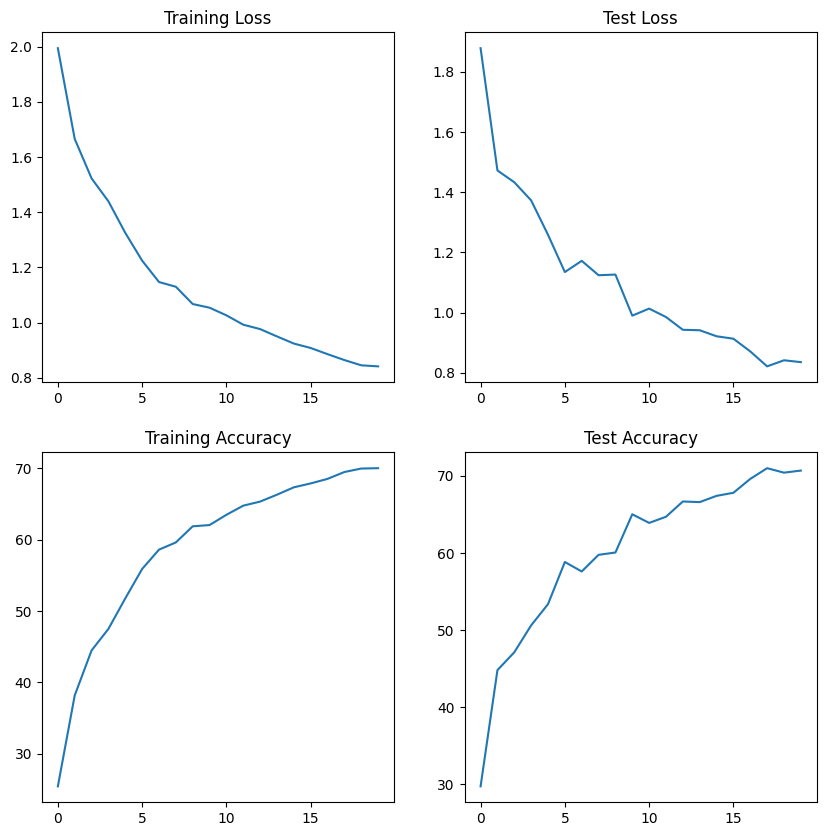

In [13]:
# Print loss and accuracy
from utils import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

## Visualize Misclassified Images

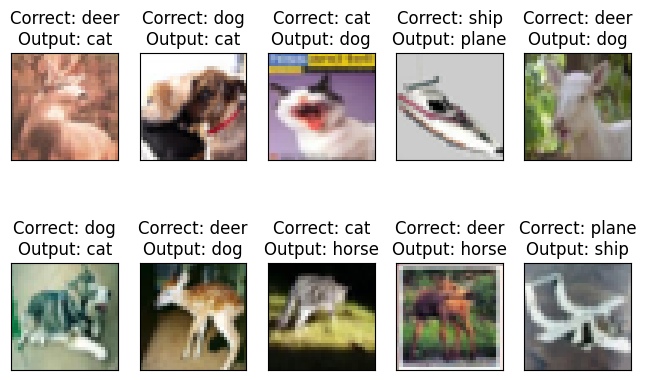

In [14]:
from utils import get_misclassified_data
from utils import plot_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
plot_data(misclassified_data, classes, inv_normalize, number_of_samples=10)